# Import libraries

In [1]:
# modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# result
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')          # graph settings
plt.rcParams['figure.figsize'] = (12,5)    # graph settings

# data wrangling
import numpy as np
import pandas as pd

# corpus
from nltk.corpus import stopwords

# string manipulation
import re
import spacy
import collections

In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Dataset

In [4]:
# First we read the two input dataset file
# One is training dataset and the other is test
train = pd.read_csv('../content/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../content/Corona_NLP_test.csv', encoding='latin1')
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Dataset size

In [5]:
# Check the length of dataset
print('Examples in train data: {}'.format(len(train)))
print('Examples in test data: {}'.format(len(test)))

Examples in train data: 41157
Examples in test data: 3798


## Missing values

In [6]:
# Check whether there are some missing values
train.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
# Delete The column Location,UserName,ScreenName,TweetAt
# The reason is that these feature are not helping us doing sentiment analysis on Tweet
train = train.drop(columns=["Location","UserName","ScreenName","TweetAt"])
train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Class distribution

In [8]:
# We want to find the distribution of data
# The reason is that  we want to make sure the training data are uniform distribution
# Which can make sure the result will not be affected by extreme value
dist_train = train['Sentiment'].value_counts()
dist_test = test['Sentiment'].value_counts()

def ditribution_plot(x, y, name):
    sns.barplot(x=x, y=y)
    plt.title(name)
    plt.show()

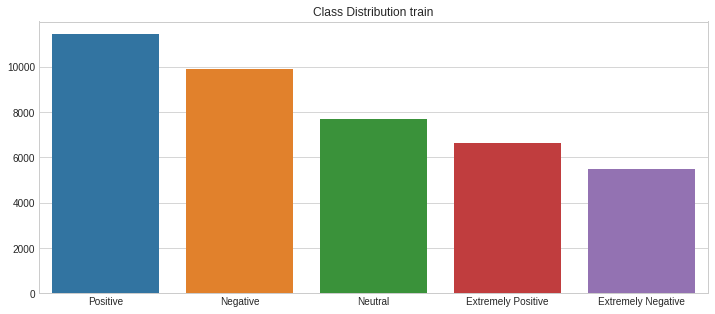

In [9]:
ditribution_plot(x=dist_train.index, y=dist_train.values, name='Class Distribution train')

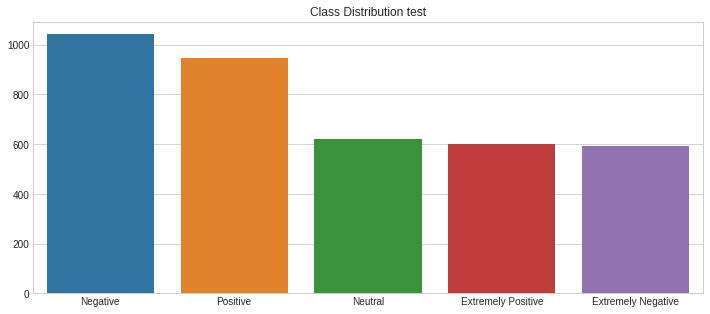

In [10]:
ditribution_plot(x=dist_test.index, y=dist_test.values, name='Class Distribution test')

# Data preprocessing

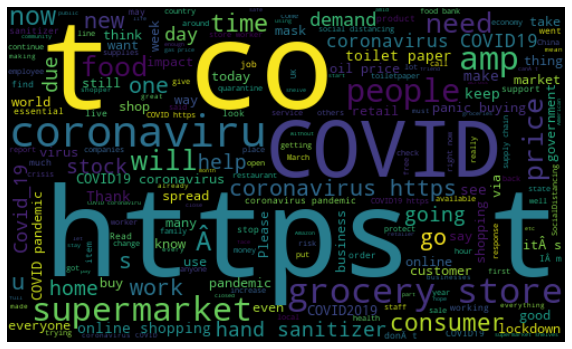

In [ ]:
# First we need to check  what is the occurrence of words
# This step will increase our final results
# Since remove unrelated word will help us better classfification
import wordcloud
from wordcloud import WordCloud
allWords = ' '.join([twts for twts in train['OriginalTweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [11]:
# This is the preprocessing of data
# Calculate average word length and sentence length
dtf = train
dtf['word_count'] = dtf["OriginalTweet"].apply(lambda x: len(str(x).split(" ")))
dtf['char_count'] = dtf["OriginalTweet"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
dtf['sentence_count'] = dtf["OriginalTweet"].apply(lambda x: len(str(x).split(".")))
dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
dtf.head()

,OriginalTweet,Sentiment,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8,104,4,13.000000,2.000000
1,advice Talk to your neighbours family to excha...,Positive,38,200,1,5.263158,38.000000
2,Coronavirus Australia: Woolworths to give elde...,Positive,14,118,2,8.428571,7.000000
3,My food stock is not the only one which is emp...,Positive,40,267,7,6.675000,5.714286
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,38,273,8,7.184211,4.750000


In [12]:
# We make a copy to make sure our further operation will not affect the the original dataset
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

## Cleaning

In [13]:
# In this step we attempt to remove any special letters like url, tag and digits
# So the dataset not contain only words that help us to train the algorithm
def data_cleaner(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet)   # remove urls
    tweet = re.sub(r'<.*?>',' ', tweet)      # remove html tags
    tweet = re.sub(r'\d+',' ', tweet)        # remove digits
    tweet = re.sub(r'#\w+',' ', tweet)       # remove hashtags
    tweet = re.sub(r'@\w+',' ', tweet)       # remove mentions
    tweet = " ".join([word for word in tweet.split() if not word in stop_words])   # remove stop words
    return tweet

stop_words = stopwords.words('english')
X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

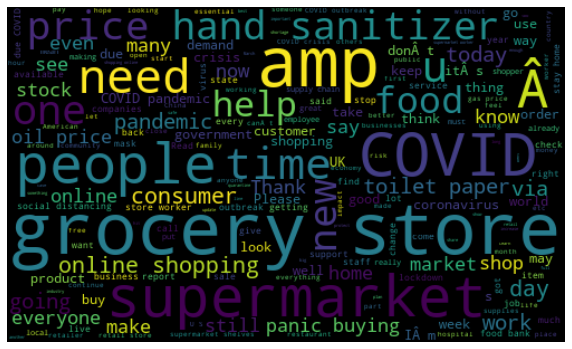

In [ ]:
# As we can see from the WordCloud
# Most of the special character and symbol are removed
# The remaining words are helpful for us when doing text classsification
allWords1 = ' '.join([twts for twts in X_cleaned])
wordCloud1 = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords1)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud1, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenizing

In [14]:
# Tokenizer breaking the raw text into small chunks
# Which helps in understanding the context or developing the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X = tokenizer.texts_to_sequences(X_cleaned)
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[6]))
print("\nAfter tokenizing :\n{}".format(X[6]))

# pad the tokenized sequences to maintain the same length across all the input sequences
X = pad_sequences(X, padding='post')
# pad either before or after each sequence
print("\nAfter padding :\n{}".format(X[6]))

Vocabulary size: 36117

Example:

Sentence:
Cashier grocery store sharing insights To prove credibility commented "I'm Civics class I know I'm talking about".

After tokenizing :
[1174, 7, 4, 1269, 761, 65, 2902, 9761, 9762, 154, 18316, 1501, 2, 62, 154, 900, 958]

After padding :
[ 1174     7     4  1269   761    65  2902  9761  9762   154 18316  1501
     2    62   154   900   958     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


## Feature encoding

In [15]:
encoding = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
y.replace(encoding, inplace=True)

# Model building and training

In [65]:
tf.keras.backend.clear_session()

# hyperparameters
# The number of complete passes through the training dataset
EPOCHS = 2
# number of samples processed before the model is updated
BATCH_SIZE = 32
# number of dimensions in the input vectors
embedding_dim = 54
units = 256

model = tf.keras.Sequential([
    # input layer that maps the words/tokenizers to a vector with embed_dim dimensions
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    # the output of the masked timestep will be zero regardless of the layer's original value
    # The unit is the output
    L.Bidirectional(L.GRU(units, return_sequences=True)),
    # Input: 3D tensor with shape: `(samples, steps, features)`.
    # output: 2D tensor with shape: `(samples, features)`. 
    L.GlobalMaxPool1D(),
    # prevent overfitting
    L.Dropout(0.5),
    # Each neuron in the dense layer receives input from all neurons of its previous layer.
    # using softmax as activation function
    # Network is using categorical crossentropy, and softmax the right activation method for that.
    L.Dense(64,activation="relu"),
    # prevent overfitting
    L.Dropout(0.5),
    # The dense is an output layer with 3 nodes
    L.Dense(5,activation="softmax"),
])

model.compile(
    loss='SparseCategoricalCrossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 54)            1950318   
                                                                 
 bidirectional (Bidirectiona  (None, 54, 512)          479232    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [66]:
history = model.fit(X, y, epochs=2, validation_split=0.2, batch_size=BATCH_SIZE)

Epoch 1/2
1029/1029 [==============================] - 15s 12ms/step - loss: 1.1167 - accuracy: 0.5380 - val_loss: 0.7004 - val_accuracy: 0.7482
Epoch 2/2
1029/1029 [==============================] - 12s 12ms/step - loss: 0.6441 - accuracy: 0.7774 - val_loss: 0.6005 - val_accuracy: 0.7855


After 2 epochs, we get overfitting

In [20]:
# Here we polot two graphs to show the trend of the accuracy and loss
def history_plot(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

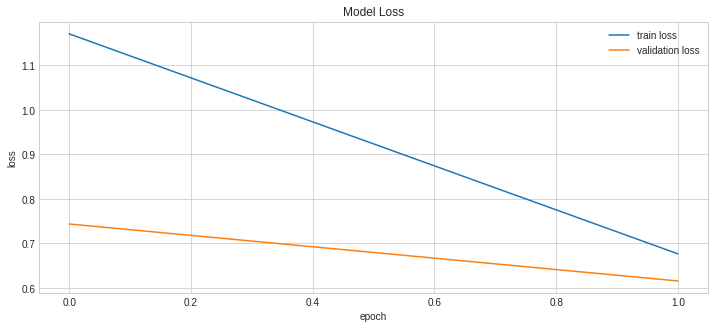

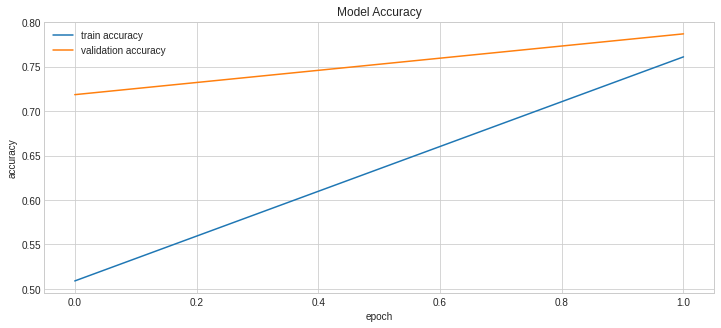

In [21]:
history_plot(history)

# Evaluation

## Preprocessing test data

In [67]:
# preprocessing test data just like above
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(data_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen=X.shape[1])
y_test.replace(encoding, inplace=True)

## Accuracy and loss

In [68]:
# get the accuracy and loss by using the model already been trained
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

119/119 [==============================] - 1s 6ms/step - loss: 0.7017 - accuracy: 0.7520
Test loss: 0.70170658826828
Test Accuracy: 0.7519747018814087


## Confusion matrix

In [69]:
pred = np.argmax(model.predict(X_test), axis=-1)

119/119 [==============================] - 1s 5ms/step


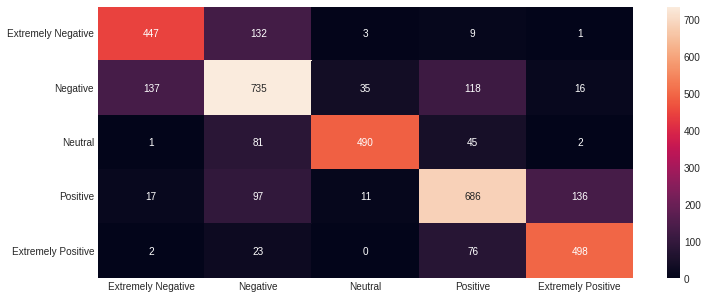

In [70]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

sns.heatmap(cm, annot=True, fmt="d")
plt.show()

## Classification report

In [72]:
print(classification_report(y_test, pred, target_names=labels))

                    precision    recall  f1-score   support

Extremely Negative       0.74      0.76      0.75       592
          Negative       0.69      0.71      0.70      1041
           Neutral       0.91      0.79      0.85       619
          Positive       0.73      0.72      0.73       947
Extremely Positive       0.76      0.83      0.80       599

          accuracy                           0.75      3798
         macro avg       0.77      0.76      0.76      3798
      weighted avg       0.76      0.75      0.75      3798

